<a href="https://colab.research.google.com/github/mennaHassanin/Bank-Customer-Churn-Prediction/blob/main/Bank_Churn_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report,f1_score
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import pickle

In [2]:
from google.colab import files
files.upload()  # This will prompt you to upload the file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mennahassanin","key":"8b8e9e1c8a2c84bc3e30ea2111cc8154"}'}

In [3]:
!ls  # This lists all files in the current directory

kaggle.json  sample_data


In [4]:
!mkdir -p ~/.kaggle  # Create the .kaggle directory
!cp kaggle.json ~/.kaggle/  # Move kaggle.json into the .kaggle folder


In [5]:
!chmod 600 ~/.kaggle/kaggle.json  # Set file permissions to secure the file

In [6]:
! kaggle competitions download -c playground-series-s4e1

 73% 5.00M/6.81M [00:00<00:00, 39.7MB/s]
100% 6.81M/6.81M [00:00<00:00, 50.9MB/s]


In [7]:
! unzip /content/playground-series-s4e1.zip

Archive:  /content/playground-series-s4e1.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [8]:
! kaggle datasets download -d shubhammeshram579/bank-customer-churn-prediction

Dataset URL: https://www.kaggle.com/datasets/shubhammeshram579/bank-customer-churn-prediction
License(s): CC0-1.0
  0% 0.00/262k [00:00<?, ?B/s]
100% 262k/262k [00:00<00:00, 95.0MB/s]


In [9]:
! unzip /content/bank-customer-churn-prediction.zip

Archive:  /content/bank-customer-churn-prediction.zip
  inflating: Churn_Modelling.csv     


In [10]:
import os

# specify the file path and current file name
old_file_path = "/content/Churn_Modelling.csv"

# specify the new file name
new_file_name = "original.csv"
dir_path = os.path.dirname(old_file_path)

# construct the new file path
new_file_path = os.path.join(dir_path, new_file_name)

# use the rename() method to rename the file
os.rename(old_file_path, new_file_path)

# EDA

In [11]:
data_original = pd.read_csv('/content/original.csv')
df_original = pd.DataFrame(data_original)
data_train=pd.read_csv('/content/train.csv')
data_test=pd.read_csv('/content/test.csv')
df_train = pd.DataFrame(data_train)
df_test = pd.DataFrame(data_test)
frames = [df_original, df_train]

In [12]:
#import gc
#del df
#gc.collect()

In [13]:
print(df_train.columns)
print(df_original.columns)

Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')
Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')


In [14]:
df_original.rename(columns={"RowNumber": "id"},inplace=True)

In [15]:
df = pd.concat(frames)

In [16]:
df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0


In [17]:
print(f'Total number of rows: {len(df.axes[0])}')
print(f'Total number of columns: {len(df.axes[1])}')

Total number of rows: 175036
Total number of columns: 14


## Check for duplicates

In [18]:
df.duplicated().sum() # two duplicates found in the original dataset

2

## Explore Unique Values

In [19]:
for col in df.columns:
  print(f'{col}: \n {df[col].unique()}')

id: 
 [     1      2      3 ... 165031 165032 165033]
CustomerId: 
 [15634602 15647311 15619304 ... 15673571 15692656 15815050]
Surname: 
 ['Hargrave' 'Hill' 'Onio' ... 'Kashiwagi' 'Aldridge' 'Burbidge']
CreditScore: 
 [619 608 502 699 850 645 822 376 501 684 528 497 476 549 635 616 653 587
 726 732 636 510 669 846 577 756 571 574 411 591 533 553 520 722 475 490
 804 582 472 465 556 834 660 776 829 637 550 698 585 788 655 601 656 725
 511 614 742 687 555 603 751 581 735 661 675 738 813 657 604 519 664 678
 757 416 665 777 543 506 493 652 750 729 646 647 808 524 769 730 515 773
 814 710 413 623 670 622 785 605 479 685 538 562 721 628 668 828 674 625
 432 770 758 795 686 789 589 461 584 579 663 682 793 691 485 650 754 535
 716 539 706 586 631 717 800 683 704 615 667 484 480 578 512 606 597 778
 514 525 715 580 807 521 759 516 711 618 643 671 689 620 676 572 695 592
 567 694 547 594 673 610 767 763 712 703 662 659 523 772 545 634 739 771
 681 544 696 766 727 693 557 531 498 651 791 733 81

## Check for Datatypes

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 175036 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               175036 non-null  int64  
 1   CustomerId       175036 non-null  int64  
 2   Surname          175036 non-null  object 
 3   CreditScore      175036 non-null  int64  
 4   Geography        175035 non-null  object 
 5   Gender           175036 non-null  object 
 6   Age              175035 non-null  float64
 7   Tenure           175036 non-null  int64  
 8   Balance          175036 non-null  float64
 9   NumOfProducts    175036 non-null  int64  
 10  HasCrCard        175035 non-null  float64
 11  IsActiveMember   175035 non-null  float64
 12  EstimatedSalary  175036 non-null  float64
 13  Exited           175036 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 20.0+ MB


* Columns `[Age]` can't be float, So Instead we need to convert it into int
* Columns `[Tenure,HasCrCard,IsActiveMember,Exited]` can't be int,so insted we need to convert them into category

## View Statistical analysis of data

In [21]:
df.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,175036.000000,1.750360e+05,175036.000000,175035.000000,175036.000000,175036.000000,175036.000000,175035.000000,175035.000000,175036.000000,175036.000000
mean,78087.096712,1.569194e+07,656.117273,38.171393,5.019904,56678.824183,1.553069,0.751187,0.498752,111861.027293,0.211151
std,49640.765370,7.142866e+04,81.151830,8.969523,2.811125,62982.466070,0.549210,0.432327,0.500000,50815.418008,0.408126
min,0.000000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,33756.750000,1.563288e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,73181.390000,0.000000
50%,77515.500000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,116969.730000,0.000000
75%,121274.250000,1.575666e+07,710.000000,42.000000,7.000000,120729.770000,2.000000,1.000000,1.000000,154767.340000,0.000000
max,165033.000000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


*   There are some outliers in `[Age,Balance,EstimatedSalary] ` based on the mean and max

## Check Missing Values

In [22]:
df.isna().sum() # Four Columns contain null values [Geography,Age,HasCrCard,IsActiveMember]

,0
id,0
CustomerId,0
Surname,0
CreditScore,0
Geography,1
Gender,0
Age,1
Tenure,0
Balance,0
NumOfProducts,0


* There is many ways to solve the missing values:
  1. Use the mode and median to fill the missing values.
  2. Use ML perdiction model like KNN or Descision Tree.
- We will Implement the both ways and train on each of them to see if there is a huge difference.

# Data Preprocessing

## Drop unwanted Features

In [23]:
df=df.drop(['id','CustomerId','Surname'],axis=1)

## Drop Duplicates

In [24]:
df=df.drop_duplicates()

## Handle Missing Values

In [25]:
# Filling the missing values by using mode and median
df['Age']=df['Age'].fillna(df['Age'].median())
df['Geography']=df['Geography'].fillna(df['Geography'].mode()[0])
df['HasCrCard']=df['HasCrCard'].fillna(df['HasCrCard'].mode()[0])
df['IsActiveMember']=df['IsActiveMember'].fillna(df['IsActiveMember'].mode()[0])

In [26]:
df.isna().sum()

,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0
HasCrCard,0
IsActiveMember,0
EstimatedSalary,0


## Converting Datatypes

In [ ]:
df['Age'] = df['Age'].astype('int64')

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 174465 entries, 0 to 165033
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CreditScore      174465 non-null  int64  
 1   Geography        174465 non-null  object 
 2   Gender           174465 non-null  object 
 3   Age              174465 non-null  int64  
 4   Tenure           174465 non-null  int64  
 5   Balance          174465 non-null  float64
 6   NumOfProducts    174465 non-null  int64  
 7   HasCrCard        174465 non-null  float64
 8   IsActiveMember   174465 non-null  float64
 9   EstimatedSalary  174465 non-null  float64
 10  Exited           174465 non-null  int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 16.0+ MB


## Handle Outliers

In [29]:
# Since the credit score data grapgh is skewed to the right and Age is skewed to left
col_outliers1=['CreditScore','Age']

for col in col_outliers1:
  lower_limit = df[col].quantile(0.05)
  upper_limit = df[col].quantile(0.95)
  df[col] = df[col].clip(lower=lower_limit, upper=upper_limit)

## Encoding

In [30]:
df = pd.get_dummies(df, columns=['Geography','Gender'])
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1.0,1.0,101348.88,1,True,False,False,True,False
1,608,41,1,83807.86,1,0.0,1.0,112542.58,0,False,False,True,True,False
2,521,42,8,159660.80,3,1.0,0.0,113931.57,1,True,False,False,True,False
3,699,39,1,0.00,2,0.0,0.0,93826.63,0,True,False,False,True,False
4,790,43,2,125510.82,1,1.0,1.0,79084.10,0,False,False,True,True,False


## Corelation Matrix

<Axes: title={'center': 'Correlation matrix'}>

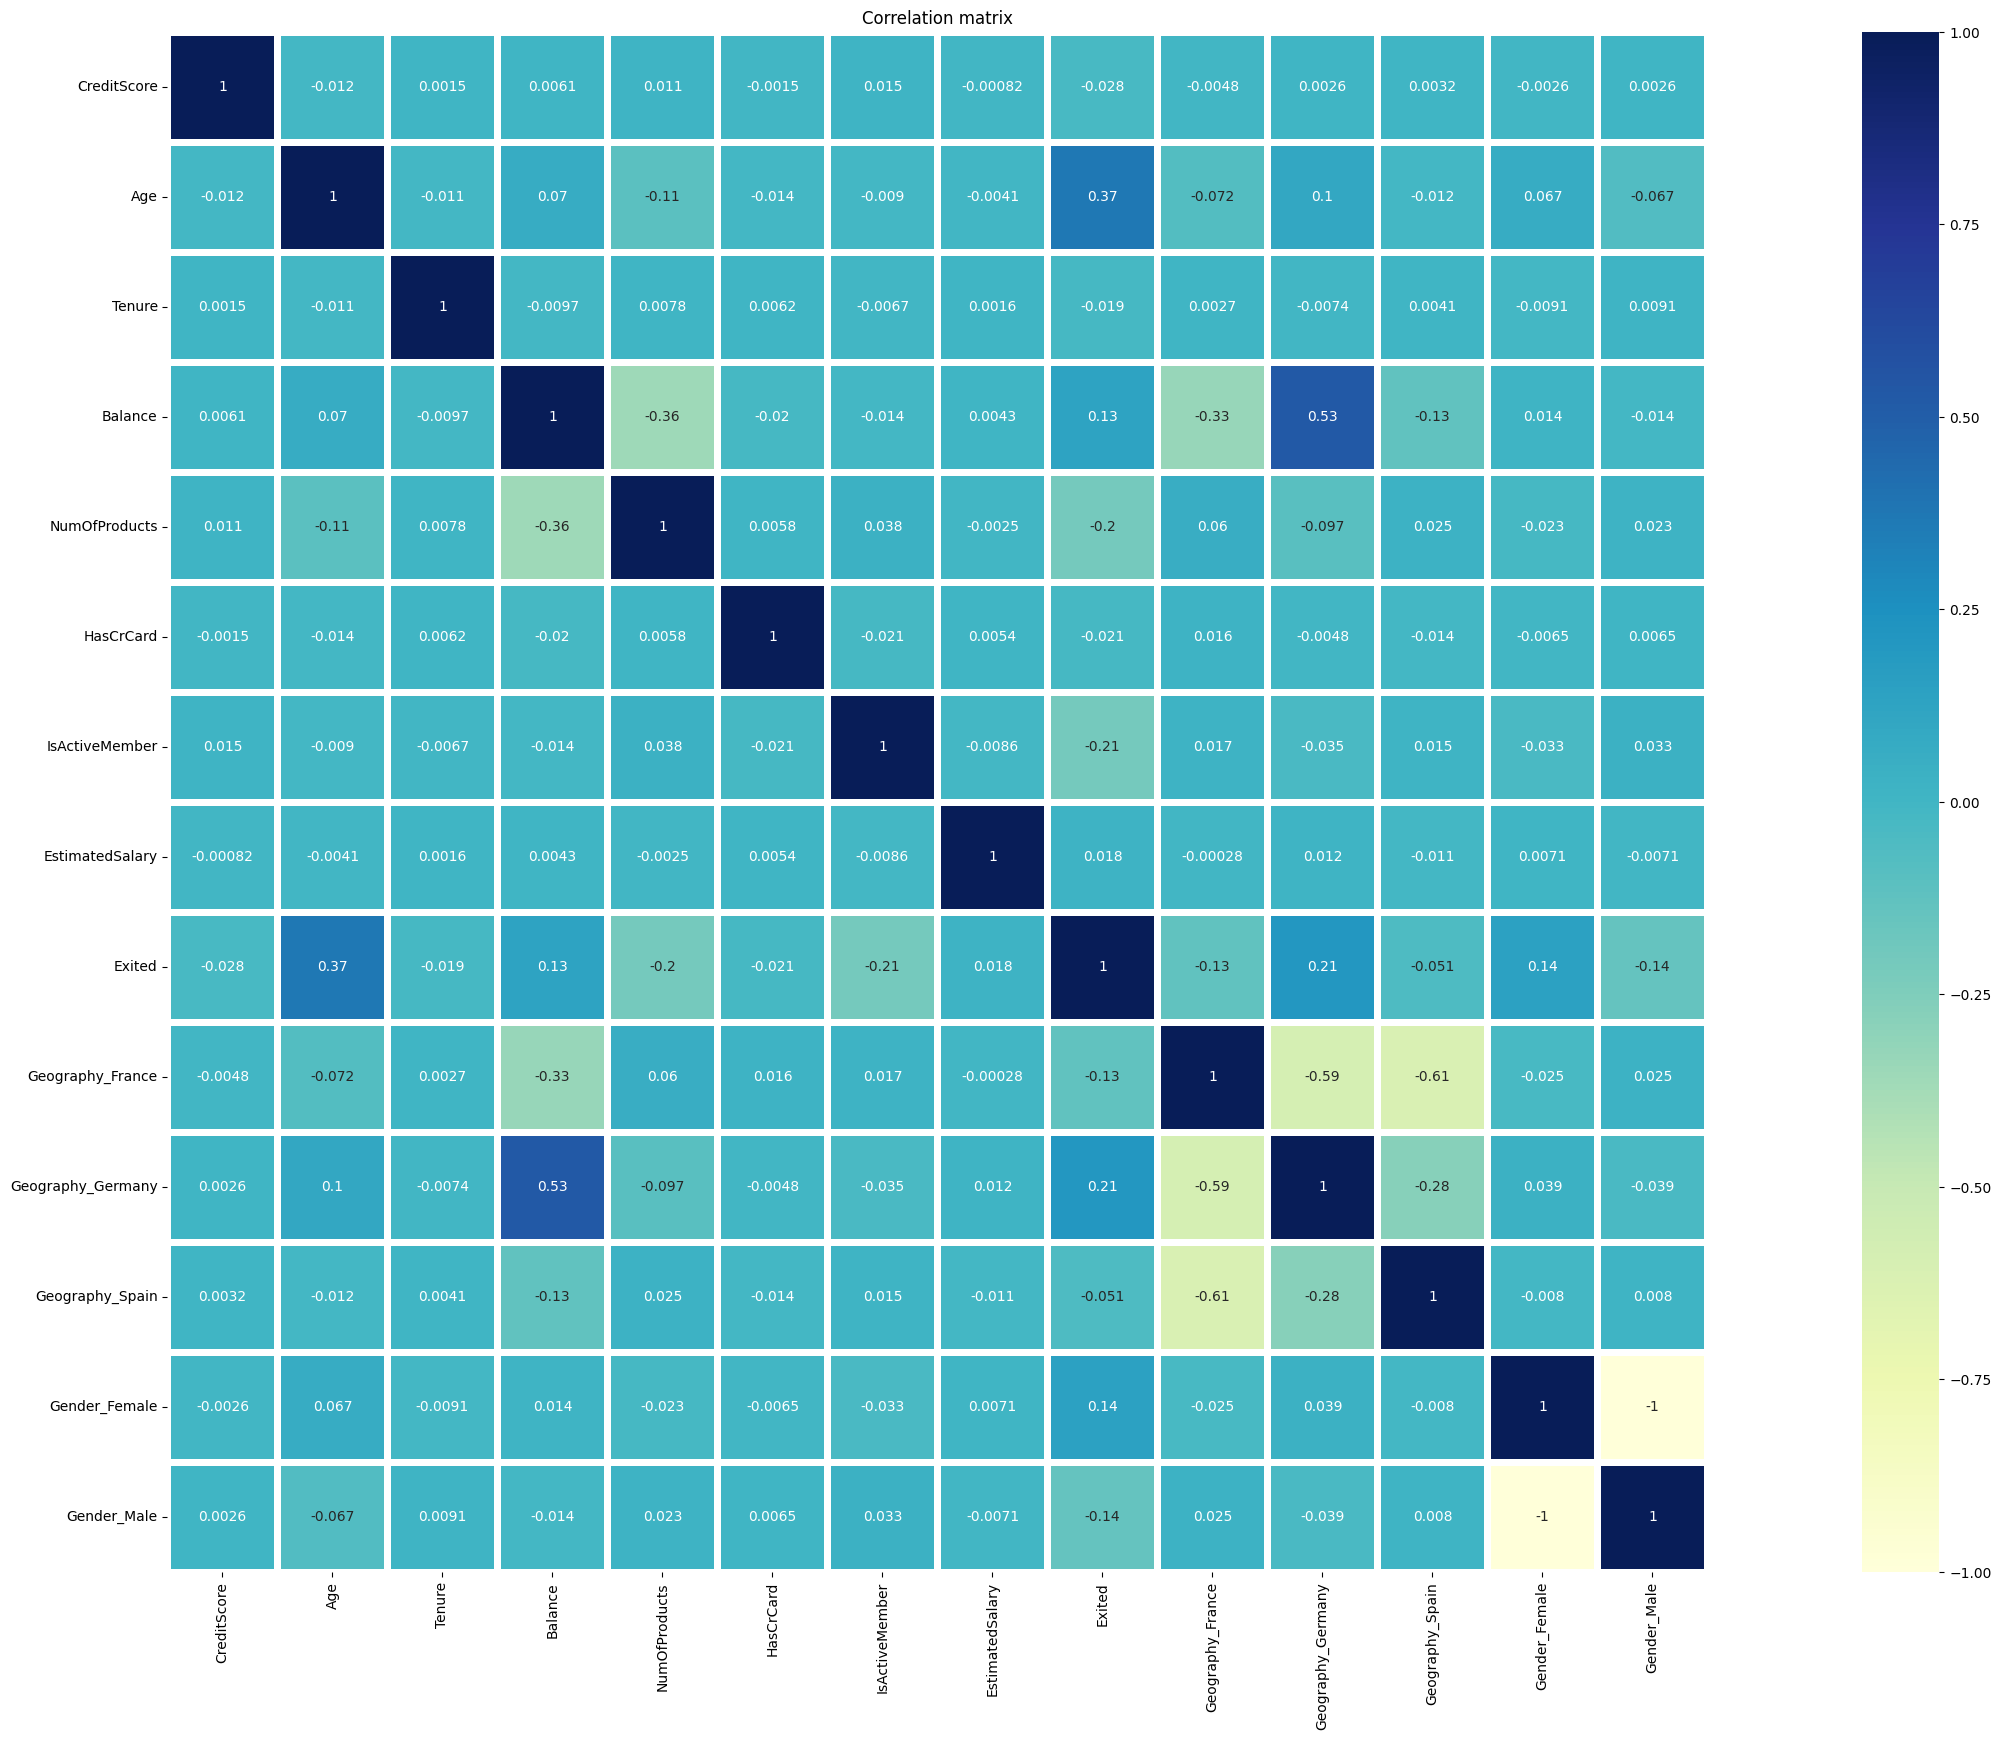

In [31]:
plt.figure(figsize=(40,20))
plt.title("Correlation matrix")
sns.heatmap(df.corr(),linewidths=5, annot=True, square=True,annot_kws={'size': 10},cmap='YlGnBu')

In [32]:
df_train = df.drop(columns='Exited',axis=1)

In [33]:
x = df.drop(columns='Exited',axis=1)
y = df['Exited']

In [34]:
print(x.columns)
print(y)

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Geography_France',
       'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male'],
      dtype='object')
0         1
1         0
2         1
3         0
4         0
         ..
165029    0
165030    0
165031    0
165032    0
165033    1
Name: Exited, Length: 174465, dtype: int64


There is no high co-related features

## Handle Unbalanced dataset

In [35]:
smote = SMOTE()
x, y = smote.fit_resample(x, y)

## Data Normalization

In [36]:
scaler = MinMaxScaler()  #Normalization of the data
x= scaler.fit_transform(x)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print(x)

[[0.36431227 0.53333333 0.2        ... 0.         1.         0.        ]
 [0.32342007 0.5        0.1        ... 1.         1.         0.        ]
 [0.         0.53333333 0.8        ... 0.         1.         0.        ]
 ...
 [0.53903346 0.5        0.4        ... 1.         1.         1.        ]
 [0.46840149 0.3        0.2        ... 0.         1.         0.        ]
 [0.27137546 0.63333333 0.8        ... 0.         1.         1.        ]]


## Spliting data

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size= 0.2, random_state=42)

In [38]:
x_train.shape,y_train.shape

((220100, 13), (220100,))

In [39]:
x_test.shape,y_test.shape

((55026, 13), (55026,))

## XGBoost

### Hyperparameter Tunning

In [40]:
classifier=XGBClassifier()

In [41]:
params={
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]

}
random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='accuracy',n_jobs=-1,cv=10,verbose=1,random_state=42)

In [42]:
random_search.fit(x_train, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7]},
                   random_state=42, scoring='accuracy', verbose=1)

In [43]:
print('Best parameters found:',random_search.best_params_)
print('Best score found:',random_search.best_score_)

Best parameters found: {'min_child_weight': 5, 'max_depth': 6, 'gamma': 0.3, 'colsample_bytree': 0.4}
Best score found: 0.9009132212630622


In [44]:
 #best model
 random_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### Modle Training & Prediction

In [45]:
model =XGBClassifier(
              colsample_bytree=0.4,
              gamma=0.3,
              max_depth=6,
              min_child_weight=5)
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [46]:
y_pred = model.predict(x_test)
y_pred_train = model.predict(x_train)

In [47]:
y_pred

array([0, 1, 1, ..., 1, 0, 1])

In [48]:
print("Train accuracy:",accuracy_score(y_train, model.predict(x_train)))
print("Test accuracy :", accuracy_score(y_test,model.predict(x_test)))

Train accuracy: 0.9067105860972285
Test accuracy : 0.9016283211572711


### Model Evaluation

In [49]:
cm=confusion_matrix(y_test,y_pred)
cm

array([[25499,  1824],
       [ 3589, 24114]])

In [50]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90     27323
           1       0.93      0.87      0.90     27703

    accuracy                           0.90     55026
   macro avg       0.90      0.90      0.90     55026
weighted avg       0.90      0.90      0.90     55026



<Axes: >

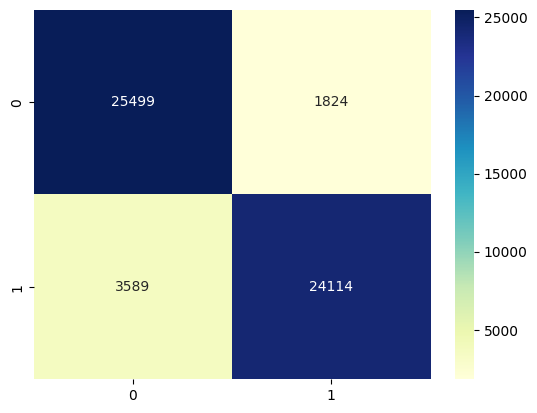

In [51]:
sns.heatmap(cm, annot=True,fmt="g", cbar=True, cmap="YlGnBu")

## SGDClassifier

In [52]:
from sklearn.linear_model import SGDClassifier

# SGDClassifier with hinge loss (equivalent to linear SVM)
sgd_svm = SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3)
sgd_svm.fit(x_train, y_train)

SGDClassifier()

In [53]:
print("Train accuracy:",accuracy_score(y_train, sgd_svm.predict(x_train)))
print("Test accuracy :", accuracy_score(y_test,sgd_svm.predict(x_test)))

Train accuracy: 0.860154475238528
Test accuracy : 0.8600843237742158


In [54]:
y_pred= sgd_svm.predict(x_test)
cm=confusion_matrix(y_test,y_pred)
cm

array([[24936,  2387],
       [ 5312, 22391]])

In [55]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.91      0.87     27323
           1       0.90      0.81      0.85     27703

    accuracy                           0.86     55026
   macro avg       0.86      0.86      0.86     55026
weighted avg       0.86      0.86      0.86     55026



## Bulding Web App

In [56]:
! pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 11.0 MB/s eta 0:00:00


In [ ]:
import gradio as gr
# Load your trained model
model.save_model("model.json")
model.load_model("model.json")  # Adjust to your model file

with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Define the prediction function
def predict_churn(CreditScore, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary, Geography, Gender):

  input_data = pd.DataFrame([[CreditScore, Geography, Gender, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary]],
                              columns=['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'])

  input_data_encoded = pd.get_dummies(input_data, columns=['Geography', 'Gender'], drop_first=True)

  # Reindex the input data to ensure it has the same columns as the training data
  input_data_encoded = input_data_encoded.reindex(columns=df_train.columns, fill_value=0)

  # Scale the combined input data using the loaded scaler
  input_data_scaled = scaler.transform(input_data_encoded)

  # Predict churn using the model
  prediction = model.predict(input_data_scaled)

  return "Exited" if prediction == 1 else "Not Exited"

# Gradio Interface
with gr.Blocks() as interface:
    gr.Markdown("## Bank Churn Prediction")

    CreditScore = gr.Number(label="Credit Score")
    Geography = gr.Dropdown(choices=["France", "Spain", "Germany"], label="Geography")
    Gender = gr.Radio(choices=["Female", "Male"], label="Gender")
    Age = gr.Number(label="Age")
    Tenure = gr.Number(label="Tenure")
    Balance = gr.Number(label="Balance")
    NumOfProducts = gr.Number(label="Number of Products")
    HasCrCard = gr.Radio(choices=[0, 1], label="Has Credit Card? (0=No, 1=Yes)")
    IsActiveMember = gr.Radio(choices=[0, 1], label="Is Active Member? (0=No, 1=Yes)")
    EstimatedSalary = gr.Number(label="Estimated Salary")

    predict_button = gr.Button("Predict")
    output = gr.Textbox(label="Churn Prediction")

    predict_button.click(predict_churn,
                         inputs=[CreditScore, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary, Geography, Gender],
                         outputs=output)

# Launch the Gradio interface
interface.launch(debug=True)


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://f5c72e4a6d3d4db887.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
